In [63]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from joblib import load
import gc
import psutil

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
#from sklearn.metrics import RocCurveDisplay as plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from io import StringIO

os.chdir('G:/Mi unidad/SOCOFAR/2.- POS-Cross-Selling/Modelo_Supervisado')
import pipeline_bm as pipeline
#pd.set_option('display.max_row', 1000000)

pipeline_bm = pipeline.clase_pipeline()

**Carga Data**

In [66]:
#tratamiento de bytes nulos en el archivo
with open('G:\\Mi unidad\\SOCOFAR\\0.-Recomendadores-Oficial\\Archivos\\Recomendaciones_PDC_OCT23\\SR_BASE_FINAL_PROD_OCT23.csv', 'rb') as file:
    content = file.read().replace(b'\x00', b'')  

content_str = StringIO(content.decode('latin'))

df = pd.read_csv(content_str, sep=';', encoding='latin')#,nrows=10000)
df['RUT_CLIENTE']=((df['SK']+1599)/2).astype(int)
print('tamaño dataset inicial: '+str(len(df)))

tamaño dataset inicial: 10000


In [3]:
# diccionario=pd.read_csv('../diccionario_productos.csv',sep=';',usecols=['CODIGO','UNIDAD_COMERCIAL','MACROCATEGORIA','CATEGORIA_NIVEL_1','CATEGORIA_NIVEL_2_FCV','DESCRIPTOR_LARGO','MARCA'])

# excl_otros = [str(elemento) for elemento in list(diccionario[diccionario.DESCRIPTOR_LARGO.isin(['DESPACHO','DESP.A','RETIRO DE RECETA','PROMOCION DTE','HORA VACUNACION','INSUMOS BOLSAS','SIN DESCRIPTOR','AJUSTE POR REDONDEO'])]['CODIGO'])] +\
#                           [str(elemento) for elemento in list(diccionario[diccionario.DESCRIPTOR_LARGO.str.contains('BOLSA PAPEL|BOLS|DESPACHO|PROMOCION|CUPON|INYECCION|MEDICION|MEMBRESIA|REGALO|2020|2021|2022|MUNDIAL')]['CODIGO'])] +\
#                           [str(elemento) for elemento in list(diccionario[diccionario.MACROCATEGORIA.isin(['ENFERMERIA ACCESORIOS Y PROCEDIMIENTOS','HOGAR','RECARGAS VARIAS','BEBIDAS Y AGUAS','ACCESORIOS MODA','TECNOLOGIA','AUTOLIQUIDABLES REGALO ARTICULOS VARIOS','INSUMOS MACRO','EQUIPOS QUIRURGICOS','POR CLASIFICAR'])]['CODIGO'])] +\
#                           [str(elemento) for elemento in list(diccionario[diccionario.CATEGORIA_NIVEL_1.isin(['MASCARILLAS PRIMEROS AUXILIOS'])]['CODIGO'])] +\
#                           [str(elemento) for elemento in list(diccionario[diccionario.UNIDAD_COMERCIAL.isin(['INSTITUCIONAL'])]['CODIGO'])]
# #por código
# cods_excluir = pd.read_csv('G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/Archivos/codigos_exclusion.csv',sep=';').excluir.values.tolist() + excl_otros
# cods_excluir = [int(cod) for cod in cods_excluir]

# diccionario=diccionario[~diccionario.CODIGO.isin(cods_excluir)]

# dicc_uam=df['CODIGO_PRODUCTO'].unique()
# dicc_productos=diccionario[diccionario.CODIGO.isin(dicc_uam)].CODIGO

# df=df[df.CODIGO_PRODUCTO.isin(dicc_productos)]
# print('tamaño dataset luego de exclusiones: '+str(len(df)))

tamaño dataset luego de exclusiones: 43671213


**Generación de Embedding de Clientes y Productos**

In [67]:
# AGRUPAR PRODUCTOS COMPRADOS POR CLIENTE EN LISTAS

# OPC1) METODO PARA PONDERAR PESO POR CANTIDAD
#sentences = df.groupby('RUT_CLIENTE')['CODIGO_PRODUCTO'].apply(list).tolist()

# OPC2) METODO PARA PONDERAR PESO POR CANTIDAD
df['PRODUCTO_CANTIDAD'] = df.apply(lambda row: [(row['CODIGO_PRODUCTO'], row['SUM_NRO_PROD'])], axis=1)

def expandir_productos_con_cantidad(lista_de_pares):
    resultado = []
    for producto, cantidad in lista_de_pares:
        resultado.extend([producto] * cantidad)
    return resultado

# función para expandir veces de aparición de los productos según su cantidad
sentences = df.groupby('RUT_CLIENTE')['PRODUCTO_CANTIDAD'].sum().apply(expandir_productos_con_cantidad).tolist()

In [71]:
model = Word2Vec(sentences, vector_size=10, window=5, min_count=1, workers=12)
model.save("modelo_word2vec.bin")

In [72]:
dicc_prod=df.CODIGO_PRODUCTO.unique()
embeddings = [model.wv[producto] for producto in dicc_prod if producto in model.wv]
dicc_prod_embedd = pd.DataFrame(embeddings, index=dicc_prod)
dicc_prod_embedd.reset_index(inplace=True)
dicc_prod_embedd.rename(columns={'index': 'CODIGO_PRODUCTO'}, inplace=True)
dicc_prod_embedd.columns = ['CODIGO_PRODUCTO'] + [f'embedding_prod_{i}' for i in range(model.vector_size)]   
dicc_prod_embedd.to_csv('productos_embeddings.csv',sep=';',index=False) 
print('Cantidad de abanico de productos: '+str(len(df.CODIGO_PRODUCTO.unique()))) 
dicc_prod_embedd.head(1)

Cantidad de abanico de productos: 3516


,CODIGO_PRODUCTO,embedding_prod_0,embedding_prod_1,embedding_prod_2,embedding_prod_3,embedding_prod_4,embedding_prod_5,embedding_prod_6,embedding_prod_7,embedding_prod_8,embedding_prod_9
0,532006,-0.045648,-0.081526,0.231496,0.091947,0.178645,0.113271,0.029554,0.097874,-0.169287,-0.064426


In [73]:
#CALCULA EL EMBEDDING DEL CLIENTE SEGUN LOS PRODUCTOS QUE HA COMPRADO
client_embeddings = {}
for rut, group in df.groupby('RUT_CLIENTE'):
    products = group['CODIGO_PRODUCTO'].tolist()
    embeddings = []
    for product in products:
        embeddings.append(model.wv[product])
        
    if embeddings:
        client_embeddings[rut] = np.mean(embeddings, axis=0)

In [75]:
#DATASET NIVEL CLIENTE CON RESPECTIVO EMBEDDING
df_cli_embedd = pd.DataFrame.from_dict(client_embeddings, orient='index')
df_cli_embedd.reset_index(inplace=True)
df_cli_embedd.columns = ['RUT_CLIENTE'] + [f'embedding_{i}' for i in range(model.vector_size)]      
print('N° de clientes: '+str(len(df_cli_embedd))) 

#CONSIDERAR SOLO CLIENTES DEL MUESTREO ESTRATIFICADO
df_cli_embedd=df_cli_embedd[df_cli_embedd.RUT_CLIENTE.isin(df.RUT_CLIENTE.unique())] 
df_cli_embedd.to_csv('clientes_embeddings.csv',sep=';',index=False) 
df_cli_embedd.head(1)

N° de clientes: 9983
N° de clientes: 9983


**Exclusiones de productos considerados para el entrenamiento**

*En este caso se entrenan productos exclusivamente recomendables solo para disminuir la carga de procesamiento con datos de productos los cuales no se consideraran en la evaluación de ser recomendados. En un excenario con más capacidad de procesamiento sería recomendable entrenar con estos datos y solo considerar el filtro de productos al momento de generar la recomendación.*

In [3]:
diccionario=pd.read_csv('../diccionario_productos.csv',sep=';',usecols=['CODIGO','UNIDAD_COMERCIAL','MACROCATEGORIA','CATEGORIA_NIVEL_1','CATEGORIA_NIVEL_2_FCV','DESCRIPTOR_LARGO','MARCA'])

excl_otros = [str(elemento) for elemento in list(diccionario[diccionario.DESCRIPTOR_LARGO.isin(['DESPACHO','DESP.A','RETIRO DE RECETA','PROMOCION DTE','HORA VACUNACION','INSUMOS BOLSAS','SIN DESCRIPTOR','AJUSTE POR REDONDEO'])]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.DESCRIPTOR_LARGO.str.contains('BOLSA PAPEL|BOLS|DESPACHO|PROMOCION|CUPON|INYECCION|MEDICION|MEMBRESIA|REGALO|2020|2021|2022|MUNDIAL')]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.MACROCATEGORIA.isin(['ENFERMERIA ACCESORIOS Y PROCEDIMIENTOS','HOGAR','RECARGAS VARIAS','BEBIDAS Y AGUAS','ACCESORIOS MODA','TECNOLOGIA','AUTOLIQUIDABLES REGALO ARTICULOS VARIOS','INSUMOS MACRO','EQUIPOS QUIRURGICOS','POR CLASIFICAR'])]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.CATEGORIA_NIVEL_1.isin(['MASCARILLAS PRIMEROS AUXILIOS'])]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.UNIDAD_COMERCIAL.isin(['INSTITUCIONAL'])]['CODIGO'])]
#por código
cods_excluir = pd.read_csv('G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/Archivos/codigos_exclusion.csv',sep=';').excluir.values.tolist() + excl_otros
cods_excluir = [int(cod) for cod in cods_excluir]

diccionario=diccionario[~diccionario.CODIGO.isin(cods_excluir)]

dicc_uam=df['CODIGO_PRODUCTO'].unique()
dicc_productos=diccionario[diccionario.CODIGO.isin(dicc_uam)].CODIGO

df=df[df.CODIGO_PRODUCTO.isin(dicc_productos)]
print('tamaño dataset luego de exclusiones: '+str(len(df)))

tamaño dataset luego de exclusiones: 43671213


## **Muestreo Estratificado**

In [4]:
caracteristicas=pd.read_csv('../SR_CARACTERISTICAS.CSV',sep=';')
df=df.merge(caracteristicas, how='left', on='RUT_CLIENTE')
df['EDAD'].replace(-1, np.nan,inplace=True)

In [5]:
min = df['EDAD'].min()
max = df['EDAD'].max()
tramos_edad = np.linspace(min, max, num=10)

df['EDAD_TRAMOS'] = pd.cut(df['EDAD'], bins=tramos_edad, include_lowest=True).astype(str)

# Específicamente asignar un tramo para NaN
df.loc[df['EDAD'].isna(), 'EDAD_TRAMOS'] = 'DESCONOCIDA'
print('tamaño dataset: '+str(len(df)))

tamaño dataset: 43671213


In [6]:
#PROCESO QUE LIMITA LA OCURRENCIA MINIMA DE UNA COMBINATORIA PARA SER PARTE DEL ESTRATIFICADO
 
porcentaje_muestra=0.5
frec_min_aparicion=1/porcentaje_muestra
print('Aparición minima de veces de una combinatoria para ser representada en la muestra: ' +str(frec_min_aparicion))

#Identificar indices de casos con muy baja ocurrencia
conteos = df.groupby(['GENERO', 'GSE', 'EDAD_TRAMOS','CODIGO_PRODUCTO']).size()
# Filtrar las combinaciones con menos de "frecuencia minima" apariciones
conteos_filtrados = conteos[conteos >= frec_min_aparicion]
# Filtrar el DataFrame original para mantener solo las filas con combinaciones relevantes en terminos de frecuencia
df_filtered = df[df.set_index(['GENERO', 'GSE', 'EDAD_TRAMOS','CODIGO_PRODUCTO']).index.isin(conteos_filtrados.index)].reset_index(drop=True)
print('tamaño dataset a realizar muestreo estratificado: '+str(len(df_filtered)))

Aparición minima de veces de una combinatoria para ser representada en la muestra: 100.0
tamaño dataset a realizar muestreo estratificado: 32245887


In [7]:
# APLICACIÓN DEL MUESTREO
test_size=1-porcentaje_muestra
df_estratificado, _ = train_test_split(df_filtered, test_size=test_size, stratify=df_filtered[['GENERO', 'GSE', 'EDAD_TRAMOS','CODIGO_PRODUCTO']])
df=df_estratificado
print('Tamaño de la muestra final: '+ str(len(df)))

Tamaño de la muestra final: 322458


In [11]:
#df_cli_embedd=pd.read_csv('clientes_embeddings.csv',sep=';')
#dicc_prod_embedd=pd.read_csv('productos_embeddings.csv',sep=';')

In [12]:
df_inter_cli_embedd = pd.merge(df[['RUT_CLIENTE','CODIGO_PRODUCTO']], df_cli_embedd, on='RUT_CLIENTE', how='left')
print('N° de interacciones cliente/producto: '+str(len(df)))  
df_inter_cli_embedd.head(1)

N° de interacciones cliente/producto: 322458


,RUT_CLIENTE,CODIGO_PRODUCTO,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9
0,16453163,295672,-1.697009,-0.813076,1.493564,-1.457752,-1.193616,0.154493,-0.121353,1.855666,-0.368019,1.951219


## **GENERACIÓN DATASET ENTRENAMIENTO**

*embedding como variables explicativas*

**Consolidación casos target=1 (todos)**

In [13]:
df_cli_prod_embedd_t1 = pd.merge(df_inter_cli_embedd, dicc_prod_embedd, on='CODIGO_PRODUCTO', how='left')
df_cli_prod_embedd_t1['TARGET']=1
print('N° de interacciones cliente/producto: '+str(len(df_cli_prod_embedd_t1)))  
df_cli_prod_embedd_t1.head(1)

N° de interacciones cliente/producto: 322458


,RUT_CLIENTE,CODIGO_PRODUCTO,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_prod_1,embedding_prod_2,embedding_prod_3,embedding_prod_4,embedding_prod_5,embedding_prod_6,embedding_prod_7,embedding_prod_8,embedding_prod_9,TARGET
0,16453163,295672,-1.697009,-0.813076,1.493564,-1.457752,-1.193616,0.154493,-0.121353,1.855666,...,-1.053332,3.121146,-1.888715,1.92968,-0.959539,-2.834627,0.562049,-0.575864,1.774845,1


**Consolidación casos target=0 (muestra)** 

###### Opción 1) muestreo aleatorio=0
###### - para cada cliente de la tabla "df_cli_embedd" se le asocie aleatoriamente un registro de la tabla "dicc_prod_embedd"

In [14]:
n = 2  # Número de veces que deseas duplicar el ratio de target 0 por sobre target 1
df_cli_prod_embedd_t0 = pd.concat([df_cli_embedd] * n, ignore_index=True)

# Paso 1: Generar índices aleatorios
num_clientes = len(df_cli_prod_embedd_t0)
indices_aleatorios = np.random.choice(dicc_prod_embedd.index, size=num_clientes, replace=True)

# Paso 2: Asignar registros aleatorios a clientes
for columna in dicc_prod_embedd.columns:
    # Usar los índices aleatorios para seleccionar los valores de dicc_prod_embedd y asignarlos a df_cli_embedd
    df_cli_prod_embedd_t0[f'{columna}'] = dicc_prod_embedd.loc[indices_aleatorios, columna].values

In [15]:
# Paso 3: Eliminar posibles casos target=1
df_cli_prod_embedd_t0 = pd.merge(df_cli_prod_embedd_t0, df[['RUT_CLIENTE','CODIGO_PRODUCTO']], on=['RUT_CLIENTE','CODIGO_PRODUCTO'], how='left', indicator=True).loc[lambda x: x['_merge'] == 'left_only']
df_cli_prod_embedd_t0 = df_cli_prod_embedd_t0.drop(columns=['_merge']) #elimina aquellos que si cruzan en el historico de transacciones
df_cli_prod_embedd_t0['TARGET']=0

###### Opción 2) Muestreo Representativo por clusters
###### Distribuir equitativamente las muestras de productos no comprados entre clientes de perfil similar, y asi no requerir que para cada cliente se consideren todos los productos que no compra.
###### - Generar 'n' clusters
###### - A cada cluster asociar aleatoriamente los 'm' productos existentes en el diccionario (cumpliendo condición de que el cliente asociado no haya comprado el producto)
###### - los 'm' productos se pueden multiplicar por un factor 'x' dependiendo de la cantidad de casos con target=0 se definan, ya sea que se opte por un entrenamiento balanceado u otro superior.

In [19]:
############## PENDIENTE ##############

**Consolidación dataset**

In [16]:
columnas = list(df_cli_prod_embedd_t0.columns)
columnas.remove('CODIGO_PRODUCTO') 
columnas.insert(1,'CODIGO_PRODUCTO')
df_cli_prod_embedd_t0 = df_cli_prod_embedd_t0[columnas]

In [17]:
pipeline_bm.dataset = pd.concat([df_cli_prod_embedd_t0,df_cli_prod_embedd_t1],axis=0)
len(pipeline_bm.dataset)

16693039

In [24]:
# import gc
# import psutil

# df_inter_cli_embedd=[]
# client_embeddings=[]
# df=[]
# df_filtered=[]
# df_cli_embedd=[]
# df_cli_prod_embedd_t0=[]
# df_cli_prod_embedd_t1=[]

# def liberar_memoria():
#     gc.collect()  # Forza la recolección de basura
#     print(f"Memoria usada después de gc.collect(): {psutil.virtual_memory().used / (1024**3):.2f} GB")

# liberar_memoria()

Memoria usada después de gc.collect(): 15.35 GB


In [18]:
excluir = ['RUT_CLIENTE', 'TARGET','CODIGO_PRODUCTO']
columnas_para_redondear = [col for col in pipeline_bm.dataset.columns if col not in excluir and (pipeline_bm.dataset[col].dtype == 'float64' or pipeline_bm.dataset[col].dtype == 'float32')]
pipeline_bm.dataset[columnas_para_redondear] = pipeline_bm.dataset[columnas_para_redondear].round(8)
print('Tamaño base de Entrenamiento: '+str(len(pipeline_bm.dataset)))  
pipeline_bm.dataset.head(1)

Tamaño base de Entrenamiento: 16693039


,RUT_CLIENTE,CODIGO_PRODUCTO,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_prod_1,embedding_prod_2,embedding_prod_3,embedding_prod_4,embedding_prod_5,embedding_prod_6,embedding_prod_7,embedding_prod_8,embedding_prod_9,TARGET
0,1000083,254766,13.480142,7.022235,-2.22646,0.83374,-5.008583,-0.929953,-0.085661,-0.808933,...,-0.097733,0.088523,-0.210696,0.045591,0.025041,0.191104,0.073073,0.077276,-0.187381,0


In [19]:
#pipeline_bm.dataset.to_csv('dataset_dev.csv',index=False,sep=';')

In [3]:
pipeline_bm.dataset=pd.read_csv('dataset_dev.csv',sep=';')

## **Modelación**

In [4]:
pipeline_bm.recibe_data(
    tipo = 'dataframe',
    dataset_o_query = '',
    target = 'TARGET',
    delimiter=';' ,
    #muestra = 'MUESTRA',
    #ano_mes = 'FECHA_VENTA',
    rut = 'RUT_CLIENTE', 
    excluir=['CODIGO_PRODUCTO'],
    categoricas=[]
)

Procesando...
cargar previamente pipeline_bm.dataset = nombre_dataframe


________________________________________________________________________________________________________________________
Datos recibidos: OK.
Número de filas y columnas del dataset: (37809170, 23)
________________________________________________________________________________________________________________________


In [5]:
pipeline_bm.separa_muestras(test=0.3)

Separacion de muestras: OK.
________________________________________________________________________________________________________________________


In [31]:
pipeline_bm.modelacion('RandomForest', perf_eval='f1',ruta_exporta='G:/Mi unidad/SOCOFAR/2.- POS-Cross-Selling/Modelo_Supervisado/modelo_rf.joblib')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=50, n_jobs=-1, oob_score=True, random_state=0;, score=0.944 total time=22.3min
[CV 2/3] END bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=50, n_jobs=-1, oob_score=True, random_state=0;, score=0.943 total time=21.1min
[CV 3/3] END bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=50, n_jobs=-1, oob_score=True, random_state=0;, score=0.943 total time=21.4min
best params: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 50, 'n_jobs': -1, 'oob_score': True, 'random_state': 0}
best estimator: RandomForestClassifier(class_weight='balanced', n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=0)
ROC: 0.978717419903467
Modelación: OK.
________________________________________________________________________________________________________________________


In [35]:
#pipeline_bm.X_test.to_csv('X_test.csv',index=False,sep=';')
#pd.DataFrame(pipeline_bm.Y_test).to_csv('Y_test.csv',index=False,sep=';')

In [6]:
pipeline_bm.model=load('D:/modelo_rf.joblib')
#pipeline_bm.X_test=pd.read_csv('X_test.csv',sep=';')
#pipeline_bm.Y_test=pd.read_csv('Y_test.csv',sep=';')
pipeline_bm.algoritmo='RandomForest'

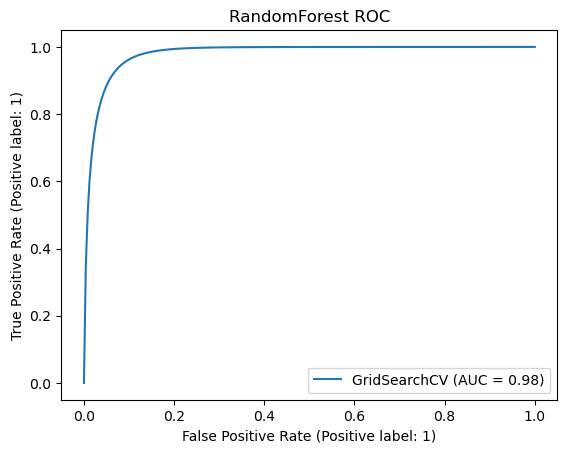

ROC: 0.978717419903467


In [13]:
%matplotlib inline
plot_roc_curve(pipeline_bm.model, pipeline_bm.X_test, pipeline_bm.Y_test)
plt.title(pipeline_bm.algoritmo + ' ROC')
plt.show()

In [11]:
pipeline_bm.metricas_modelo_optimo()
pipeline_bm.confusion_matrix

"ROC OPTIMO"

sens+espc:  1.8640811753964184
KS:  0.8640811753964183
threshold optimo:  0.559
sensibility:  0.9520366137134457
specificity:  0.9120445616829725
precision:  0.9341190995838141
negative predictive value:  0.9355514393380275
Critical Success Index:  0.8921346147374487
accuracy:  0.9347235957132445
f1score:  0.9429927530407141
BalancedAccuracy:  0.9320405876982092


TARGET,0,1
pred,,
0,4478510,308517
1,431897,6123827


Lo esperable es que el modelo ajuste en extremo bien ya que se le proporcionan implicitamente lo productos que compró a través del embedding del cliente. 
Lo importante acá es que, de cara al uso, la probabilidad hacia un producto no comprado por el cliente será más alta en la medida en que el embedding del cliente contenga el resto de productos que normalmente los clientes compran junto con el.

No confundir el acierto del modelo en el conjunto de test con el grado de efectividad esperado en las recomendaciones. Para esto último se puede realizar una aproximación más realista mediante una evaluación "offline" en un conjunto de datos OOT.

## **EVALUACIÓN EN OOT**

* Se evalúa en ventana temporal posterior al train/test la performance del modelo 
* Escenarios: 
    1) Se consideraran todos los productos excepto exclusiones; escenario de aprendizaje
    2) Se consideraran productos no comprados en el periodo de train/test y no excluidos; escenario ácido/real.


In [2]:
#importar MODELO Y VARIABLES del desarrollo
#model=Word2Vec.load("modelo_word2vec.bin")
pipeline_bm.threshold=0.559
clientes_embedd=pd.read_csv('clientes_embeddings.csv',sep=';')
productos_embedd=pd.read_csv('productos_embeddings.csv',sep=';')

**1) Evaluación modelo mismas condiciones considerando todos los productos (incluye ya comprados, pero se filtran productos excluidos)--> Escenario Entrenamiento**

In [33]:
with open('G:\\Mi unidad\\SOCOFAR\\0.-Recomendadores-Oficial\\Archivos\\Recomendaciones_PDC_NOV23_ENE24\\SR_BASE_FINAL_PROD_NOV23_ENE24.csv', 'rb') as file:
    content = file.read().replace(b'\x00', b'')
    
content_str = StringIO(content.decode('latin'))
df_test_oot = pd.read_csv(content_str, sep=';', encoding='latin')#,nrows=10000000)
df_test_oot['RUT_CLIENTE']=((df_test_oot['SK']+1599)/2).astype(int)
print('tamaño dataset inicial: '+str(len(df_test_oot)))

tamaño dataset inicial: 25320225


In [34]:
#no considerar predicciones sobre productos no recomendables (exclusiones)
diccionario=pd.read_csv('../diccionario_productos.csv',sep=';',usecols=['CODIGO','UNIDAD_COMERCIAL','MACROCATEGORIA','CATEGORIA_NIVEL_1','CATEGORIA_NIVEL_2_FCV','DESCRIPTOR_LARGO','MARCA'])

excl_otros = [str(elemento) for elemento in list(diccionario[diccionario.DESCRIPTOR_LARGO.isin(['DESPACHO','DESP.A','RETIRO DE RECETA','PROMOCION DTE','HORA VACUNACION','INSUMOS BOLSAS','SIN DESCRIPTOR','AJUSTE POR REDONDEO'])]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.DESCRIPTOR_LARGO.str.contains('BOLSA PAPEL|BOLS|DESPACHO|PROMOCION|CUPON|INYECCION|MEDICION|MEMBRESIA|REGALO|2020|2021|2022|MUNDIAL')]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.MACROCATEGORIA.isin(['ENFERMERIA ACCESORIOS Y PROCEDIMIENTOS','HOGAR','RECARGAS VARIAS','BEBIDAS Y AGUAS','ACCESORIOS MODA','TECNOLOGIA','AUTOLIQUIDABLES REGALO ARTICULOS VARIOS','INSUMOS MACRO','EQUIPOS QUIRURGICOS','POR CLASIFICAR'])]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.CATEGORIA_NIVEL_1.isin(['MASCARILLAS PRIMEROS AUXILIOS'])]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.UNIDAD_COMERCIAL.isin(['INSTITUCIONAL'])]['CODIGO'])]

cods_excluir = pd.read_csv('G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/Archivos/codigos_exclusion.csv',sep=';').excluir.values.tolist() + excl_otros
cods_excluir = [int(cod) for cod in cods_excluir]
df_test_oot_1=df_test_oot[~df_test_oot.CODIGO_PRODUCTO.isin(cods_excluir)]

#Generación dataset de variables explicativas de los clientes del OOT (en base a información de DEV)
#1)carga de clientes con los respectivos productos comprados dataframe OOT y caracteristicas (embedding cliente)
df_test_oot_1=pd.merge(df_test_oot_1[['RUT_CLIENTE','CODIGO_PRODUCTO']],clientes_embedd,on='RUT_CLIENTE',how='left')
df_test_oot_1=df_test_oot_1.dropna(subset=['RUT_CLIENTE'])
#Elimina clientes nuevos (sin embbeding) --> en escenario "COLD START" a estos primero se les calcula el embedding de cliente de acuerdo a un grupo de productos proporcionado
df_test_oot_1=df_test_oot_1.dropna(subset=['RUT_CLIENTE','embedding_0'])

#2) Complemento con emmbeding de los respectivos productos comprados en el OOT --> si producto no se encuentra solo se podría deber a que es un producto no existente en compras del UAM
df_test_oot_1=pd.merge(df_test_oot_1,productos_embedd,on='CODIGO_PRODUCTO',how='left')
df_test_oot_1=df_test_oot_1.dropna(subset=['RUT_CLIENTE','embedding_prod_0'])
df_test_oot_1['TARGET']=1


In [35]:
#Evaluación solo de clientes en OOT
df_test_oot_0=pd.merge(df_test_oot[['RUT_CLIENTE']].drop_duplicates(),clientes_embedd,on='RUT_CLIENTE',how='left')
df_test_oot_0=df_test_oot_0.dropna(subset=['RUT_CLIENTE','embedding_0'])

n=1 #veces que duplicar a los clientes para muestrear no comprados
df_test_oot_0 = pd.concat([df_test_oot_0] * n, ignore_index=True)

# Paso 1: Generar índices aleatorios
num_clientes = len(df_test_oot_0)
productos_embedd=productos_embedd[~productos_embedd.CODIGO_PRODUCTO.isin(cods_excluir)]
indices_aleatorios = np.random.choice(productos_embedd.index, size=num_clientes, replace=True)

# Paso 2: Asignar registros aleatorios a clientes
for columna in productos_embedd.columns:
    # Usar los índices aleatorios para seleccionar los valores de productos_embedd y asignarlos a df_cli_embedd
    df_test_oot_0[f'{columna}'] = productos_embedd.loc[indices_aleatorios, columna].values

# Paso 3: Eliminar posibles casos target=1
df_test_oot_0 = pd.merge(df_test_oot_0, df_test_oot[['RUT_CLIENTE','CODIGO_PRODUCTO']], on=['RUT_CLIENTE','CODIGO_PRODUCTO'], how='left', indicator=True).loc[lambda x: x['_merge'] == 'left_only']
df_test_oot_0 = df_test_oot_0.drop(columns=['_merge']) #elimina aquellos que si cruzan en el historico de transacciones
columnas = list(df_test_oot_0.columns)
columnas.remove('CODIGO_PRODUCTO') 
columnas.insert(1,'CODIGO_PRODUCTO')
df_test_oot_0 = df_test_oot_0[columnas]    

df_test_oot_0['TARGET']=0

In [36]:
df_test_oot_final = pd.concat([df_test_oot_0,df_test_oot_1],axis=0)

In [37]:
df_test_oot_1=[]
df_test_oot_0=[]
gc.collect()

105

In [39]:
# df_test_oot_final = df_test_oot_final.groupby('TARGET', group_keys=False).apply(lambda x: x.sample(frac=0.3)) --> en caso de ser necesario muestrear
#- Prediccion de modelo respecto de esos productos considerando el threshold del modelo optimo  (Recall) ==> Para esta validación considera solo el vector de productos vendidos por cliente y no la predicción sobre los "no vendidos" (TN y FN) solo por un tema de volumen de procesamiento
threshold=pipeline_bm.threshold
#threshold=pipeline_bm.threshold
pipeline_bm.model = load('modelo_rf.joblib')
df_test_oot_final['PROBABILIDAD']=pipeline_bm.model.predict_proba(df_test_oot_final.iloc[:,2:-1])[:,1]
df_test_oot_final['PREDICT'] = (df_test_oot_final['PROBABILIDAD'] > threshold).astype(int)

pd.crosstab(df_test_oot_final.PREDICT,df_test_oot_final.TARGET)

TARGET,0,1
PREDICT,,
0,3430489,2065135
1,731561,9637298


In [40]:
print(classification_report(df_test_oot_final.TARGET, df_test_oot_final.PREDICT, target_names=['No Recommend','Recommended']))

              precision    recall  f1-score   support

No Recommend       0.62      0.82      0.71   4162050
 Recommended       0.93      0.82      0.87  11702433

    accuracy                           0.82  15864483
   macro avg       0.78      0.82      0.79  15864483
weighted avg       0.85      0.82      0.83  15864483



**2) Evaluación exclusiva de productos complementarios (excluye comprados en UAM y se filtran productos excluidos) --> Escenario Real**

In [3]:
with open('G:\\Mi unidad\\SOCOFAR\\0.-Recomendadores-Oficial\\Archivos\\Recomendaciones_PDC_NOV23_ENE24\\SR_BASE_FINAL_PROD_NOV23_ENE24.csv', 'rb') as file:
    content = file.read().replace(b'\x00', b'')

content_str = StringIO(content.decode('latin'))
df_test_oot = pd.read_csv(content_str, sep=';', encoding='latin')#,nrows=10000000)
df_test_oot['RUT_CLIENTE']=((df_test_oot['SK']+1599)/2).astype(int)
print('tamaño dataset inicial: '+str(len(df_test_oot)))

tamaño dataset inicial: 25320225


In [4]:
#tratamiento de bytes nulos en el archivo
with open('G:\\Mi unidad\\SOCOFAR\\0.-Recomendadores-Oficial\\Archivos\\Recomendaciones_PDC_OCT23\\SR_BASE_FINAL_PROD_OCT23.csv', 'rb') as file:
    content = file.read().replace(b'\x00', b'')  

content_str = StringIO(content.decode('latin'))
df = pd.read_csv(content_str, sep=';', encoding='latin')#,nrows=1000000)
df['RUT_CLIENTE']=((df['SK']+1599)/2).astype(int)
print('tamaño dataset inicial: '+str(len(df)))

tamaño dataset inicial: 89797463


In [5]:
#Excluye productos comprados anteriormente UAM --> Se restringe a evaluacion productos no comprados por el cliente en DEV (ya que se recomendaran productos complementarios no comprados anteriormente por el cliente)
df_test_oot=pd.merge(df_test_oot[['RUT_CLIENTE','CODIGO_PRODUCTO']],df,on=['RUT_CLIENTE','CODIGO_PRODUCTO'],how='left')
df_test_oot=df_test_oot[df_test_oot.SK.isna()]
df_test_oot.head(1)

#No considerar predicciones sobre productos no recomendables (exclusiones)
diccionario=pd.read_csv('../diccionario_productos.csv',sep=';',usecols=['CODIGO','UNIDAD_COMERCIAL','MACROCATEGORIA','CATEGORIA_NIVEL_1','CATEGORIA_NIVEL_2_FCV','DESCRIPTOR_LARGO','MARCA'])

excl_otros = [str(elemento) for elemento in list(diccionario[diccionario.DESCRIPTOR_LARGO.isin(['DESPACHO','DESP.A','RETIRO DE RECETA','PROMOCION DTE','HORA VACUNACION','INSUMOS BOLSAS','SIN DESCRIPTOR','AJUSTE POR REDONDEO'])]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.DESCRIPTOR_LARGO.str.contains('BOLSA PAPEL|BOLS|DESPACHO|PROMOCION|CUPON|INYECCION|MEDICION|MEMBRESIA|REGALO|2020|2021|2022|MUNDIAL')]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.MACROCATEGORIA.isin(['ENFERMERIA ACCESORIOS Y PROCEDIMIENTOS','HOGAR','RECARGAS VARIAS','BEBIDAS Y AGUAS','ACCESORIOS MODA','TECNOLOGIA','AUTOLIQUIDABLES REGALO ARTICULOS VARIOS','INSUMOS MACRO','EQUIPOS QUIRURGICOS','POR CLASIFICAR'])]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.CATEGORIA_NIVEL_1.isin(['MASCARILLAS PRIMEROS AUXILIOS'])]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.UNIDAD_COMERCIAL.isin(['INSTITUCIONAL'])]['CODIGO'])]

cods_excluir = pd.read_csv('G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/Archivos/codigos_exclusion.csv',sep=';').excluir.values.tolist() + excl_otros
cods_excluir = [int(cod) for cod in cods_excluir]

df_test_oot=df_test_oot[~df_test_oot.CODIGO_PRODUCTO.isin(cods_excluir)]

In [6]:
#Generación dataset de variables explicativas de los clientes del OOT (en base a información de DEV)
#1)Carga de clientes con los respectivos productos comprados dataframe OOT y caracteristicas (embedding cliente)
df_test_oot_1=pd.merge(df_test_oot[['RUT_CLIENTE','CODIGO_PRODUCTO']],clientes_embedd,on='RUT_CLIENTE',how='left')
df_test_oot_1=df_test_oot_1.dropna(subset=['RUT_CLIENTE'])

#Elimina clientes nuevos (sin embbeding) --> en escenario "COLD START" a estos primero se les calcula el embedding de cliente de acuerdo a un grupo de productos proporcionado
df_test_oot_1=df_test_oot_1.dropna(subset=['RUT_CLIENTE','embedding_0'])

#2) Complemento con emmbeding de los respectivos productos comprados en el OOT --> si producto no se encuentra solo se podría deber a que es un producto no existente en compras del UAM
df_test_oot_1=pd.merge(df_test_oot_1,productos_embedd,on='CODIGO_PRODUCTO',how='left')
df_test_oot_1=df_test_oot_1.dropna(subset=['RUT_CLIENTE','embedding_prod_0'])

df_test_oot_1['TARGET']=1

In [7]:
#Evaluación solo de clientes en OOT
df_test_oot_0=pd.merge(df_test_oot[['RUT_CLIENTE']].drop_duplicates(),clientes_embedd,on='RUT_CLIENTE',how='left')
df_test_oot_0=df_test_oot_0.dropna(subset=['RUT_CLIENTE','embedding_0'])

n=1 #veces que duplicar a los clientes para muestrear no comprados
df_test_oot_0 = pd.concat([df_test_oot_0] * n, ignore_index=True)

# Paso 1: Generar índices aleatorios
num_clientes = len(df_test_oot_0)
productos_embedd=productos_embedd[~productos_embedd.CODIGO_PRODUCTO.isin(cods_excluir)]
indices_aleatorios = np.random.choice(productos_embedd.index, size=num_clientes, replace=True)

# Paso 2: Asignar registros aleatorios a clientes
for columna in productos_embedd.columns:
    # Usar los índices aleatorios para seleccionar los valores de productos_embedd y asignarlos a df_cli_embedd
    df_test_oot_0[f'{columna}'] = productos_embedd.loc[indices_aleatorios, columna].values

# Paso 3: Eliminar posibles casos target=1
df_test_oot_0 = pd.merge(df_test_oot_0, df_test_oot[['RUT_CLIENTE','CODIGO_PRODUCTO']], on=['RUT_CLIENTE','CODIGO_PRODUCTO'], how='left', indicator=True).loc[lambda x: x['_merge'] == 'left_only']
df_test_oot_0 = df_test_oot_0.drop(columns=['_merge']) #elimina aquellos que si cruzan en el historico de transacciones
columnas = list(df_test_oot_0.columns)
columnas.remove('CODIGO_PRODUCTO') 
columnas.insert(1,'CODIGO_PRODUCTO')
df_test_oot_0 = df_test_oot_0[columnas]    

df_test_oot_0['TARGET']=0

In [8]:
df_test_oot_final = pd.concat([df_test_oot_0,df_test_oot_1],axis=0)

In [9]:
df_test_oot_1=[]
df_test_oot_0=[]
gc.collect()
print(f"Memoria usada después de gc.collect(): {psutil.virtual_memory().used / (1024**3):.2f} GB")

Memoria usada después de gc.collect(): 8.03 GB


In [10]:
#- Prediccion de modelo respecto de esos productos considerando el threshold del modelo optimo  (Recall) ==> Para esta validación considera solo el vector de productos vendidos por cliente y no la predicción sobre los "no vendidos" (TN y FN) solo por un tema de volumen de procesamiento
threshold=pipeline_bm.threshold
pipeline_bm.model = load('modelo_rf.joblib')
df_test_oot_final['PROBABILIDAD']=pipeline_bm.model.predict_proba(df_test_oot_final.iloc[:,2:-1])[:,1]
df_test_oot_final['PREDICT'] = (df_test_oot_final['PROBABILIDAD'] > threshold).astype(int)

In [18]:
pd.crosstab(df_test_oot_final.PREDICT,df_test_oot_final.TARGET)

TARGET,0,1
PREDICT,,
0,2389538,2040915
1,580599,7639967


In [19]:
print(classification_report(df_test_oot_final.TARGET, df_test_oot_final.PREDICT, target_names=['No Recommend','Recommended']))

              precision    recall  f1-score   support

No Recommend       0.54      0.80      0.65   2970137
 Recommended       0.93      0.79      0.85   9680882

    accuracy                           0.79  12651019
   macro avg       0.73      0.80      0.75  12651019
weighted avg       0.84      0.79      0.80  12651019



**REVISIONES CASOS**

In [42]:
diccionario=pd.read_csv('G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/Archivos/diccionario_productos.csv',sep=';',encoding='UTF-8')
df_test_oot_final = pd.merge(df_test_oot_final, diccionario, left_on='CODIGO_PRODUCTO', right_on='CODIGO', how='left')
df_test_oot = pd.merge(df_test_oot, diccionario, left_on='CODIGO_PRODUCTO', right_on='CODIGO', how='left')
df = pd.merge(df, diccionario, left_on='CODIGO_PRODUCTO', right_on='CODIGO', how='left')

In [48]:
df_test_oot_final[(df_test_oot_final.TARGET==1) & (df_test_oot_final.PREDICT==1)][5:10]

,RUT_CLIENTE,CODIGO_PRODUCTO,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,PROBABILIDAD,PREDICT,CODIGO,UNIDAD_COMERCIAL,MACROCATEGORIA,CATEGORIA_NIVEL_1,CATEGORIA_NIVEL_2_FCV,DESCRIPTOR_LARGO,MARCA,GENERO
2970175,12531168,296818,1.062703,-0.470706,2.053578,-1.265371,0.567018,-0.538847,0.466072,-0.079015,...,0.98,1,296818.0,BELLEZA Y CUIDADO PERSONAL,CUIDADO FACIAL,ESTUCHES CUIDADO FACIAL,CUIDADO FACIAL ESTUCHES,PETRIZZIO HIDRA SHOCK CREMA HIDRATANTE INT.DIA...,PETRIZZIO,SIN CLASIFICACION
2970176,10033077,298057,-0.720849,-0.204217,-0.282643,0.026229,-0.529279,-1.021251,-2.269705,-0.025283,...,1.00,1,298057.0,BELLEZA Y CUIDADO PERSONAL,HIGIENE BUCAL,CEPILLOS DENTALES,INTERDENTAL,PHB CEPILLO INTERDENTAL FLEXI EXTRAFINO DOBLE ...,PHB,NO APLICA
2970177,6013860,541879,1.041929,-0.719336,-0.774628,0.941536,0.267588,0.346594,-0.983223,-0.640467,...,0.92,1,541879.0,FARMA,ANALGESIA,DOLOR Y FIEBRE,DOLOR Y FIEBRE ANALGESIA,ALIVIDOL COMPRIMIDOS 1 GRAMO X20,ALIVIDOL,SIN CLASIFICACION
2970178,9106274,268493,0.854340,0.955198,-0.075103,0.902365,-0.622136,1.165381,-3.114947,-0.512445,...,0.72,1,268493.0,BELLEZA Y CUIDADO PERSONAL,DESODORANTES CORPORALES,DEO MUJER,DEO MUJER BARRA,LADY SPEED STICK PRO 5 EN1 DESODORANTE BARRA 4...,LADY SPEED STICK,MUJER
2970179,16539815,276819,0.116905,-0.045271,-0.423868,-1.088375,0.883589,-0.760762,2.013361,0.627242,...,0.98,1,276819.0,BELLEZA Y CUIDADO PERSONAL,DESODORANTES CORPORALES,DEO HOMBRE,DEO HOMBRE SPRAY,OLD SPICE DESODORANTE BODY SPRAY LENA 150ML,OLD SPICE,HOMBRE


In [15]:
with open('G:\\Mi unidad\\SOCOFAR\\0.-Recomendadores-Oficial\\Archivos\\Recomendaciones_PDC_NOV23_ENE24\\SR_BASE_FINAL_PROD_NOV23_ENE24.csv', 'rb') as file:
    content = file.read().replace(b'\x00', b'')

content_str = StringIO(content.decode('latin'))
df_test_oot = pd.read_csv(content_str, sep=';', encoding='latin')#,nrows=10000000)
df_test_oot['RUT_CLIENTE']=((df_test_oot['SK']+1599)/2).astype(int)
print('tamaño dataset inicial: '+str(len(df_test_oot)))

tamaño dataset inicial: 25320225


In [52]:
df[(df.RUT_CLIENTE==9106274)]

,SK,CODIGO_PRODUCTO,SUM_NRO_PROD,RUT_CLIENTE,CODIGO,UNIDAD_COMERCIAL,MACROCATEGORIA,CATEGORIA_NIVEL_1,CATEGORIA_NIVEL_2_FCV,DESCRIPTOR_LARGO,MARCA,GENERO
22206426,18210949,541174,1,9106274,541174.0,BELLEZA Y CUIDADO PERSONAL,CUIDADO FACIAL,HIDRATACION FACIAL,CUIDADO FACIAL HIDRATACION,LOREAL REVITALIFT RETINOL SERUM NOCHE ARRUGAS ...,LOREAL,NO APLICA
28117856,18210949,297248,1,9106274,297248.0,BELLEZA Y CUIDADO PERSONAL,HIGIENE BUCAL,ENJUAGUE BUCAL,ENJUAGUE BUCAL ADULTO,COLGATE TOTAL12 ENJUAGUE BUCAL ANTIBACTERIAL C...,COLGATE,SIN CLASIFICACION
51487230,18210949,295624,1,9106274,295624.0,FARMA,ANALGESIA,ANTIINFLAMATORIOS,ANTIINFLAMATORIOS SISTEMICOS,COXIRA CAPSULAS 200MG.10,COXIRA,SIN CLASIFICACION
68243744,18210949,275395,1,9106274,275395.0,FARMA,GASTRICAS,ANTIEMETICOS,ANTIEMETICOS OTC,BETINA COMPRIMIDOS 24MG. 30,BETINA,SIN CLASIFICACION
74769000,18210949,266503,1,9106274,266503.0,FARMA,CARDIOVASCULAR,HIPOTENSORES,HIPOTENSORES CARDIOVASCULAR,"BISOPRIL COMPRIMIDOS RECUBIERTOS 2,5 MILIGRAMO...",BISOPRIL,SIN CLASIFICACION
84022071,18210949,525714,1,9106274,525714.0,BIENESTAR Y CONSUMO,VITAMINAS Y MINERALES,SUPLEMENTOS,SISTEMA DIGESTIVO BIENESTAR,PURE SCIENCE PROBIOTIC DAILY CAPSULAS X60,PURE SCIENCE,SIN CLASIFICACION


In [53]:
df_test_oot[(df_test_oot.RUT_CLIENTE==9106274)]

,SK,CODIGO_PRODUCTO,SUM_NRO_PROD,RUT_CLIENTE,CODIGO,UNIDAD_COMERCIAL,MACROCATEGORIA,CATEGORIA_NIVEL_1,CATEGORIA_NIVEL_2_FCV,DESCRIPTOR_LARGO,MARCA,GENERO
36,18210949,268493,2,9106274,268493.0,BELLEZA Y CUIDADO PERSONAL,DESODORANTES CORPORALES,DEO MUJER,DEO MUJER BARRA,LADY SPEED STICK PRO 5 EN1 DESODORANTE BARRA 4...,LADY SPEED STICK,MUJER
3909025,18210949,277416,1,9106274,277416.0,BIENESTAR Y CONSUMO,BEBIDAS Y AGUAS,BEBIDAS FUNCIONALES,BEBIDAS FUNCIONALES BIENESTAR,OKF ALOE DRINK VERA BEBIDA DE ALOE VERA SIN AZ...,OKF,SIN CLASIFICACION
6021784,18210949,544133,1,9106274,544133.0,BELLEZA Y CUIDADO PERSONAL,HIGIENE BUCAL,PASTAS DENTALES,PASTAS DENTALES ADULTO,SENSODYNE PASTA DENTAL PROTECCION COMPLETA CRE...,SENSODYNE,NO APLICA
9389716,18210949,193115,1,9106274,193115.0,FARMA,SISTEMA NERVIOSO,HIPNOTICOS,HIPNOTICOS SIST NERVIOSO,"ZONIX COMPRIMIDOS RECUBIERTOS 7,5 MILIGRAMOS 30",ZONIX,SIN CLASIFICACION
10483252,18210949,286986,1,9106274,286986.0,FARMA,ANTIINFECCIOSOS,ANTISEPTICOS ANTIINFECCIOSOS,ANTISEPTICO DERMICO,MUPAX CREMA TOPICA 2% 15GR,MUPAX,SIN CLASIFICACION
14206973,18210949,291803,1,9106274,291803.0,FARMA,ALERGIAS,ANTIPRURIGINOSOS ALERGIAS,ANTIHISTAMINICO,LEVOCETIRIZINA BIOEQUIVALENTE COMPRIMIDOS RECU...,LEVOCETIRIZINA,SIN CLASIFICACION
16727838,18210949,270079,3,9106274,270079.0,FARMA,CARDIOVASCULAR,DIURETICOS,DIURETICOS CARDIOVASCULAR,FUROSEMIDA BIOEQUIVALENTE COMPRIMIDOS 40 MG.12,FUROSEMIDA,SIN CLASIFICACION
21038457,18210949,87031,2,9106274,87031.0,FARMA,CARDIOVASCULAR,VASODILATADORES,VASODIL CEREBRAL Y PERIFERICO,FLUXUS COMPRIMIDOS 10 MILIGRAMOS 30,FLUXUS,SIN CLASIFICACION
22630624,18210949,544147,1,9106274,544147.0,BELLEZA Y CUIDADO PERSONAL,HIGIENE BUCAL,CEPILLOS DENTALES,CEPILLOS DENTALES ADULTO,COLGATE CEPILLO DENTAL RECYCLEAN CERDAS A BASE...,COLGATE,SIN CLASIFICACION


In [54]:
#COMPRAS EN TEST
df_test_oot_final[(df_test_oot_final.RUT_CLIENTE==9106274)]

,RUT_CLIENTE,CODIGO_PRODUCTO,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,PROBABILIDAD,PREDICT,CODIGO,UNIDAD_COMERCIAL,MACROCATEGORIA,CATEGORIA_NIVEL_1,CATEGORIA_NIVEL_2_FCV,DESCRIPTOR_LARGO,MARCA,GENERO
11,9106274,399479,0.85434,0.955198,-0.075103,0.902365,-0.622136,1.165381,-3.114947,-0.512445,...,0.00,0,399479.0,BELLEZA Y CUIDADO PERSONAL,CUIDADO FACIAL DERMO,HIDRATACION FACIAL DERMO,HIDRATACION FACIAL DERMO PIEL SECA,BIOTHERM AQUASOURCE CREMA RICH HIDRATACION CON...,BIOTHERM,MUJER
2970178,9106274,268493,0.85434,0.955198,-0.075103,0.902365,-0.622136,1.165381,-3.114947,-0.512445,...,0.72,1,268493.0,BELLEZA Y CUIDADO PERSONAL,DESODORANTES CORPORALES,DEO MUJER,DEO MUJER BARRA,LADY SPEED STICK PRO 5 EN1 DESODORANTE BARRA 4...,LADY SPEED STICK,MUJER
5272324,9106274,544133,0.85434,0.955198,-0.075103,0.902365,-0.622136,1.165381,-3.114947,-0.512445,...,0.96,1,544133.0,BELLEZA Y CUIDADO PERSONAL,HIGIENE BUCAL,PASTAS DENTALES,PASTAS DENTALES ADULTO,SENSODYNE PASTA DENTAL PROTECCION COMPLETA CRE...,SENSODYNE,NO APLICA
8392309,9106274,291803,0.85434,0.955198,-0.075103,0.902365,-0.622136,1.165381,-3.114947,-0.512445,...,0.96,1,291803.0,FARMA,ALERGIAS,ANTIPRURIGINOSOS ALERGIAS,ANTIHISTAMINICO,LEVOCETIRIZINA BIOEQUIVALENTE COMPRIMIDOS RECU...,LEVOCETIRIZINA,SIN CLASIFICACION
11617899,9106274,544147,0.85434,0.955198,-0.075103,0.902365,-0.622136,1.165381,-3.114947,-0.512445,...,0.36,0,544147.0,BELLEZA Y CUIDADO PERSONAL,HIGIENE BUCAL,CEPILLOS DENTALES,CEPILLOS DENTALES ADULTO,COLGATE CEPILLO DENTAL RECYCLEAN CERDAS A BASE...,COLGATE,SIN CLASIFICACION


In [37]:
#COMPRAS DEV
df[(df.RUT_CLIENTE==10590691) & (df.CODIGO_PRODUCTO==257913)]

,SK,CODIGO_PRODUCTO,SUM_NRO_PROD,RUT_CLIENTE


## **USO DEL MODELO RECOMENDADOR**

- se recibe el cliente y producto buscado
- se calcula el embedding del cliente como la ponderacion de items historicos + el nuevo
- se calcula la probabilidad de compra para ese embedding en combinatoria con todos los embedding de productos existentes
- se seleccionan aquellos "n" con probabilidad más alta (sin compra previa)

In [ ]:
#[rut_cliente,producto-1,...,producto-n]
vector=[1768451,261034,277430,254222]
cliente=vector[0]
productos=vector[1:]

embedding cliente

In [ ]:
historico=df[df.RUT_CLIENTE==cliente].CODIGO_PRODUCTO.tolist()
total=historico+productos

In [ ]:
embeddings = []
for product in total:
    embeddings.append(model.wv[product])
        
if embeddings:
    client_embedding = np.mean(embeddings, axis=0)

para cada producto se concatena embedding cliente y producto

In [ ]:
productos = list(model.wv.index_to_key)  # Obtener todos los productos para los cuales el modelo tiene un embedding
embeddings = [model.wv[producto] for producto in productos]  # Lista de embeddings

embeddings_df = pd.DataFrame(embeddings)

# Agregar columna de productos
embeddings_df.insert(0, 'CODIGO_PRODUCTO', productos)

In [ ]:
df_client_embedding = pd.DataFrame([client_embedding], columns=[f'EMBEDDING_{i}' for i in range(len(client_embedding))])
df_client_embedding = pd.concat([df_client_embedding]*len(embeddings_df), ignore_index=True)
df_client_embedding_final = pd.concat([df_client_embedding, embeddings_df], axis=1)
df_x = df_client_embedding_final.drop(columns=['CODIGO_PRODUCTO'])
df_productos=pd.DataFrame(df_client_embedding_final.CODIGO_PRODUCTO)

predicciones y rankeo

In [ ]:
preds=pd.DataFrame(pipeline_bm.model.predict_proba(df_x)[:,1],columns=['PROBABILIDAD'])

In [ ]:
prod_pred=pd.concat([df_productos,preds],axis=1)
prod_pred_final=prod_pred.sort_values(by='PROBABILIDAD',ascending=False).head(5).CODIGO_PRODUCTO.values.tolist()  

In [ ]:
prod_pred_final

[254222, 291144, 528441, 272447, 268668]